### library

In [24]:
import pandas as pd
from datetime import datetime, timedelta
from pytz import UTC
import json
import matplotlib.pyplot as plt
import yaml
from docx import Document

### dataframe

In [25]:
json_path = '/data/output.json'

with open(json_path, 'r') as file:
    lines = file.readlines()
    json_data = ''.join(lines)
    data = json.loads(json_data)

proposals = [proposal for proposal in data["data"]["component"]["proposals"]["nodes"] if proposal["state"] not in ["rejected", "withdrawn"]]

df = pd.DataFrame(proposals)

df['publishedAt'] = pd.to_datetime(df['publishedAt'])
df['updatedAt'] = pd.to_datetime(df['updatedAt'])

### general data

In [26]:
end_date = datetime.now(UTC)
start_date = end_date - timedelta(days=7)

proposals_week = df[(df['publishedAt'] >= start_date) & (df['publishedAt'] <= end_date)]

def calcular_totais(data):
    num_propostas = len(data)
    num_votos = data['voteCount'].sum()
    num_comentarios = data['totalCommentsCount'].sum()
    return num_propostas, num_votos, num_comentarios

totais_gerais = calcular_totais(df)

totais_semanais = calcular_totais(proposals_week)

'''print(f"Totais Gerais: Número Total de Propostas: {totais_gerais[0]}, Número Total de Votos: {totais_gerais[1]}, Total de Comentários: {totais_gerais[2]}")
print(f"Totais Semanais: Número Total de Propostas: {totais_semanais[0]}, Número Total de Votos: {totais_semanais[1]}, Total de Comentários: {totais_semanais[2]}")'''

'print(f"Totais Gerais: Número Total de Propostas: {totais_gerais[0]}, Número Total de Votos: {totais_gerais[1]}, Total de Comentários: {totais_gerais[2]}")\nprint(f"Totais Semanais: Número Total de Propostas: {totais_semanais[0]}, Número Total de Votos: {totais_semanais[1]}, Total de Comentários: {totais_semanais[2]}")'

### line graphs

/tmp/ipykernel_46007/34970384.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Data'] = df['publishedAt'].dt.date


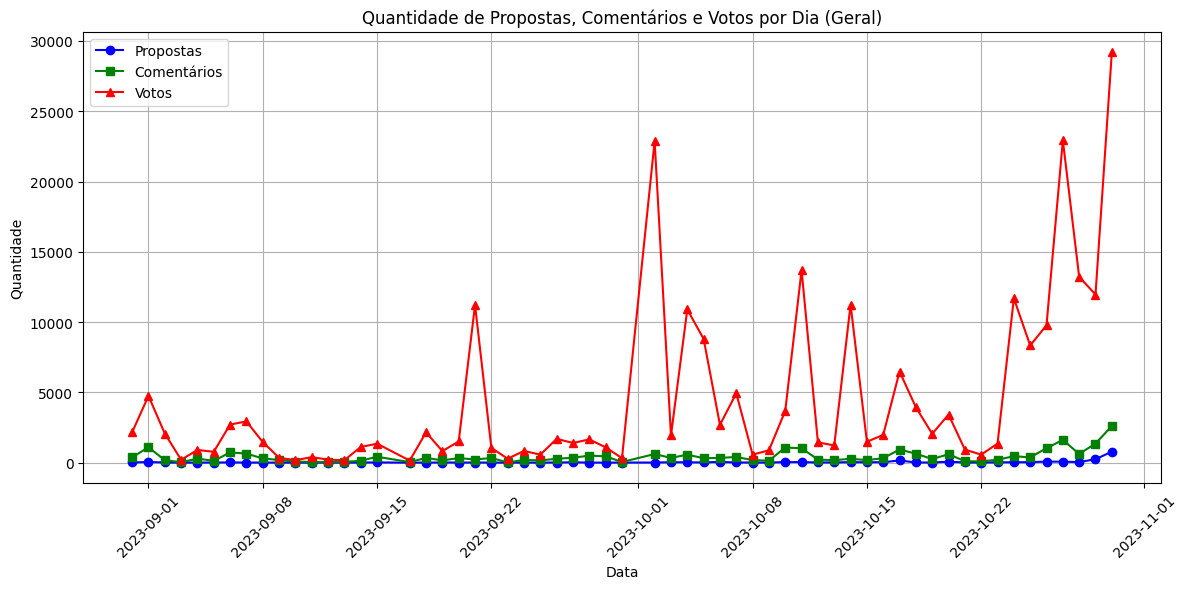

In [33]:
df['Data'] = df['publishedAt'].dt.date

n_proposals = df.groupby('Data')['id'].count()
n_comments = df.groupby('Data')['totalCommentsCount'].sum()
n_votes = df.groupby('Data')['voteCount'].sum()

plt.figure(figsize=(12, 6))
plt.plot(n_proposals.index, n_proposals.values, label='Propostas', color='blue', marker='o')
plt.plot(n_comments.index, n_comments.values, label='Comentários', color='green', marker='s')
plt.plot(n_votes.index, n_votes.values, label='Votos', color='red', marker='^')

plt.xlabel('Data')
plt.ylabel('Quantidade')
plt.title('Quantidade de Propostas, Comentários e Votos por Dia (Geral)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

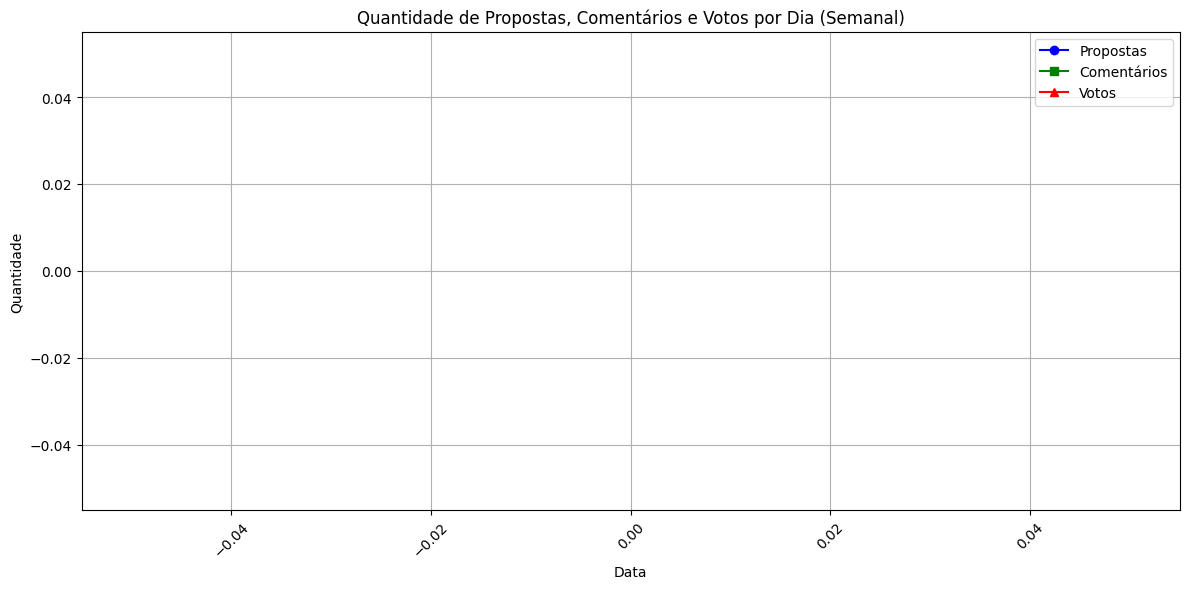

In [34]:
df_week = df[(df['publishedAt'] >= start_date) & (df['publishedAt'] <= end_date)]

df_week['Data'] = df_week['publishedAt'].dt.date

n_proposals = df_week.groupby('Data')['id'].count()
n_comments = df_week.groupby('Data')['totalCommentsCount'].sum()
n_votes = df_week.groupby('Data')['voteCount'].sum()

plt.figure(figsize=(12, 6))
plt.plot(n_proposals.index, n_proposals.values, label='Propostas', color='blue', marker='o')
plt.plot(n_comments.index, n_comments.values, label='Comentários', color='green', marker='s')
plt.plot(n_votes.index, n_votes.values, label='Votos', color='red', marker='^')

plt.xlabel('Data')
plt.ylabel('Quantidade')
plt.title('Quantidade de Propostas, Comentários e Votos por Dia (Semanal)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

### top proposals

In [35]:
df_ranking = df.sort_values(by='voteCount', ascending=False)

top_proposals = df_ranking.head(20)

columns = ['id', 'title', 'category', 'voteCount', 'totalCommentsCount']
top_proposals = top_proposals[columns]


### category

In [36]:
df['nome_tema'] = df['category'].apply(lambda x: x['name']['translation'] if x and 'name' in x and 'translation' in x['name'] else None)

df = df.dropna(subset=['nome_tema'])

rank_temas = df.groupby('nome_tema')['id'].count().reset_index()
rank_temas.columns = ['Tema', 'Quantidade de Propostas']

rank_temas['Quantidade de Votos'] = df.groupby('nome_tema')['voteCount'].sum().values
rank_temas['Quantidade de Comentários'] = df.groupby('nome_tema')['totalCommentsCount'].sum().values

rank_temas = rank_temas.sort_values(by='Quantidade de Propostas', ascending=False)



/tmp/ipykernel_46007/781314233.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['nome_tema'] = df['category'].apply(lambda x: x['name']['translation'] if x and 'name' in x and 'translation' in x['name'] else None)


In [4]:
yaml_path = '/report/text.yaml'

with open(yaml_path, 'r') as yaml_file:
    data = yaml.safe_load(yaml_file)

md_filename = '/report/report.md'

with open(md_filename, 'w') as md_file:
    for key, value in data.items():
        md_file.write(f"## {key.capitalize()}\n\n")
        md_file.write('\n'.join(value))
        md_file.write('\n\n')

docx_filename = '/report/report.docx'

doc = Document()
for key, value in data.items():
    doc.add_heading(key.capitalize(), level=2)
    for paragraph in value:
        doc.add_paragraph(paragraph)
    doc.add_paragraph('\n')

doc.save(docx_filename)

### commit